Simulation of Melagen Ground Station

In [9]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import re

# generate random sample
# 7200 samples x 26 bytes = 187200 bytes
# packet structure: [D1R1][D1R2][D2R1][D2R2][D3R1][D3R2][D4R1][D4R2][D5R1][D5R2][CRC]
# 7200 samples x 22 bytes = 158400 bytes
# (7200 x 22) / 64 = 2475 blocks

# using 0x80040000 to 0x80080000 uses 262144 bytes
# 262144 / (1440 x 22) = 8.274 days worth of data stored

# a data frame with each observation will have dose and sensor label

ADC_REF = 2500  # mV
ADC_MAX_VAL = 2048 - 1
ADC_TO_MV = ADC_REF / ADC_MAX_VAL  # ≈ 1.221 mV per ADC count

r1 = 243000 #r1 on voltage divider
r2 = 200000 #r2 on voltage divider

sensor_weights = {
    "D1": 0.5,   # tends toward lower values
    "D2": 0.7,
    "D3": 1.0,   # baseline
    "D4": 1.3,
    "D5": 1.5    # tends toward higher values
}

def generate_packet_correlated(
    base_min=500,
    base_max=ADC_MAX_VAL,
    noise_sigma_pct=0.02,   # ~2% of base as noise scale
    rho=0.01,                # correlation between R1 and R2 (0..1)
):
    readings = []
    for s in range(1, 6):
        key = f"D{s}"
        w = sensor_weights[key]
        base = int(random.randint(base_min, base_max) * w)
        base = max(0, min(base, ADC_MAX_VAL))

        sigma = max(1, int(base * noise_sigma_pct))
        # common noise shared by R1 & R2
        common = int(random.gauss(0, sigma))
        # independent noise parts
        indep1 = int(random.gauss(0, sigma))
        indep2 = int(random.gauss(0, sigma))

        # combine: higher rho -> more of the shared component
        r1 = base + int(rho * common + (1 - rho) * indep1)
        r2 = base + int(rho * common + (1 - rho) * indep2)

        for v in (r1, r2):
            readings.append(max(0, min(v, ADC_MAX_VAL)))

    crc = sum(readings) % 65535
    return readings + [crc]

def actual_voltage(Vout, r1, r2):
    # Vo = Vi (r2 / r1+r2)
    return Vout / (r2 / (r1+r2))

def dose_from_V(V, A, B):
    # V = A x Dose ^ B
    # Dose = (V/A) ^ (1/B)
    return (V / A) ** (1/ B)

def expand_packet(packet):
    """
    Expand one packet into dataframe format:
    columns: [sensor, adc_value, voltage_mV]
    """
    data = []
    for sensor in range(1, 6):
        for reading in range(1, 3):
            idx = (sensor - 1) * 2 + (reading - 1)
            adc_val = packet[idx]
            mv_val = adc_val * ADC_TO_MV
            V_val = mv_val / 1000 # Vout

            V_actual = actual_voltage(V_val, r1, r2) #Vin
            dose_100 = dose_from_V(V_actual, 0.02951, 0.45509)
            # dose_50 = dose_from_V(V_actual, 0.0241, 0.4752)
            # dose_10 = dose_from_V(V_actual, 0.0068, 0.6164)
            # dose_5 = dose_from_V(V_actual, 0.0033, 0.7062)
            # dose_1 = dose_from_V(V_actual, 0.0008, 0.9119)
            data.append({
                "sensor": f"D{sensor}R{reading}",
                "adc_value": adc_val,
                "voltage_mV": mv_val,
                "voltage_V": V_val,
                "voltage_actual": V_actual,
                "dose 0-100k": dose_100 ,
                # "dose 0-50k": dose_50,
                # "dose 0-10k": dose_10,
                # "dose 0-5k": dose_5,
                # "dose 0-1k": dose_1
            })
    return pd.DataFrame(data)

# Generate multiple packet
packets = [generate_packet_correlated() for _ in range(100)]  

# Expand all packets into one dataframe
df = pd.concat([expand_packet(pkt) for pkt in packets], ignore_index=True)

df.head(10)

,sensor,adc_value,voltage_mV,voltage_V,voltage_actual,dose 0-100k
0,D1R1,776,947.728383,0.947728,2.099218,11741.375434
1,D1R2,790,964.826575,0.964827,2.137091,12211.874913
2,D2R1,655,799.951148,0.799951,1.771892,8089.987489
3,D2R2,665,812.164143,0.812164,1.798944,8363.870257
4,D3R1,1095,1337.322912,1.337323,2.962170,25023.068325
5,D3R2,1080,1319.003420,1.319003,2.921593,24276.022478
6,D4R1,741,904.982902,0.904983,2.004537,10609.038104
7,D4R2,747,912.310699,0.912311,2.020768,10798.714413
8,D5R1,1282,1565.705911,1.565706,3.468039,35383.672043
9,D5R2,1318,1609.672692,1.609673,3.565425,37603.778581


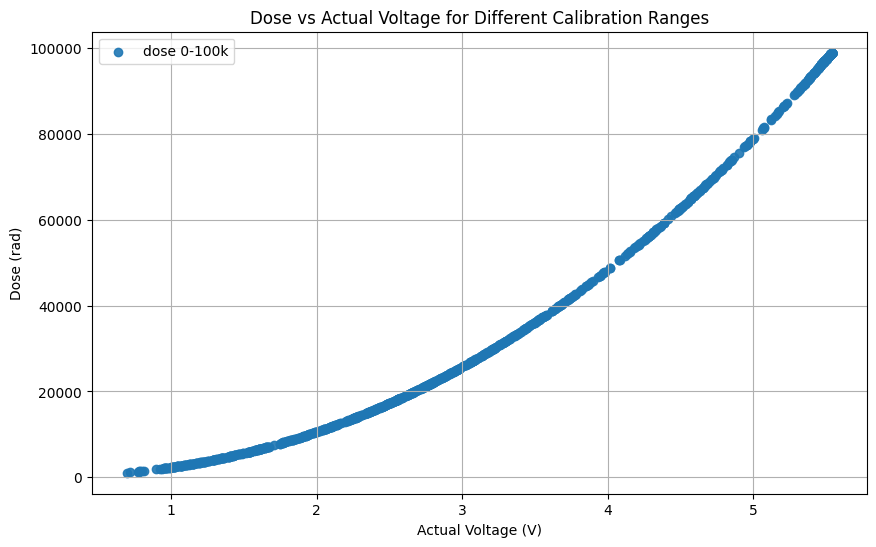

In [10]:
plt.figure(figsize=(10, 6))

dose_columns = ["dose 0-100k"]#, "dose 0-50k", "dose 0-10k", "dose 0-5k", "dose 0-1k"]
for col in dose_columns:
    plt.scatter(df["voltage_actual"], df[col], label=col, alpha=0.9)

plt.xlabel("Actual Voltage (V)")
plt.ylabel("Dose (rad)")
plt.title("Dose vs Actual Voltage for Different Calibration Ranges")
plt.legend()
plt.grid(True)
plt.show()

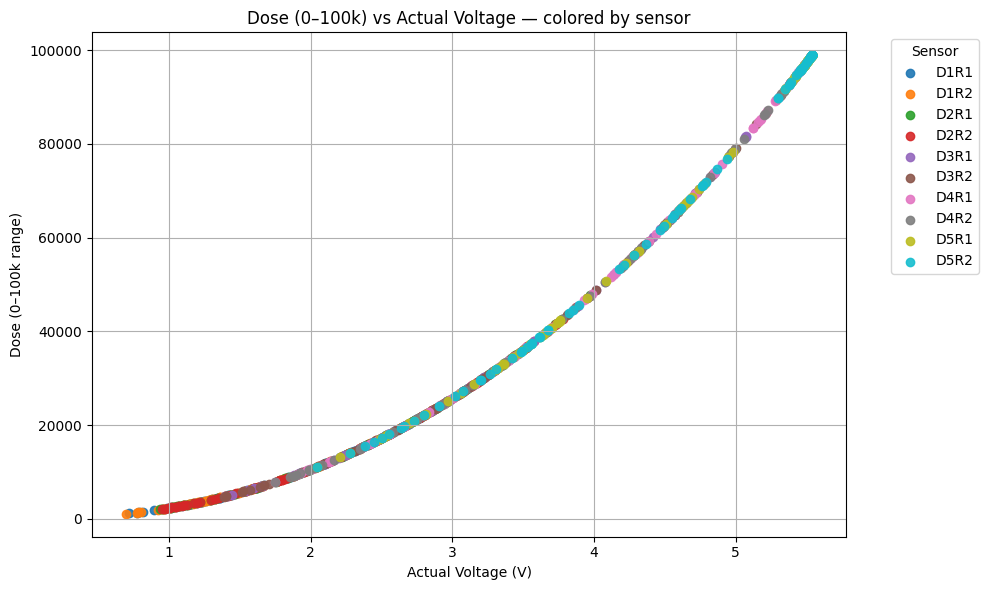

In [11]:
plt.figure(figsize=(10, 6))

for sensor, grp in df.groupby("sensor"):
    plt.scatter(grp["voltage_actual"], grp["dose 0-100k"], label=sensor, alpha=0.9)

plt.xlabel("Actual Voltage (V)")
plt.ylabel("Dose (0–100k range)")
plt.title("Dose (0–100k) vs Actual Voltage — colored by sensor")
plt.legend(title="Sensor", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

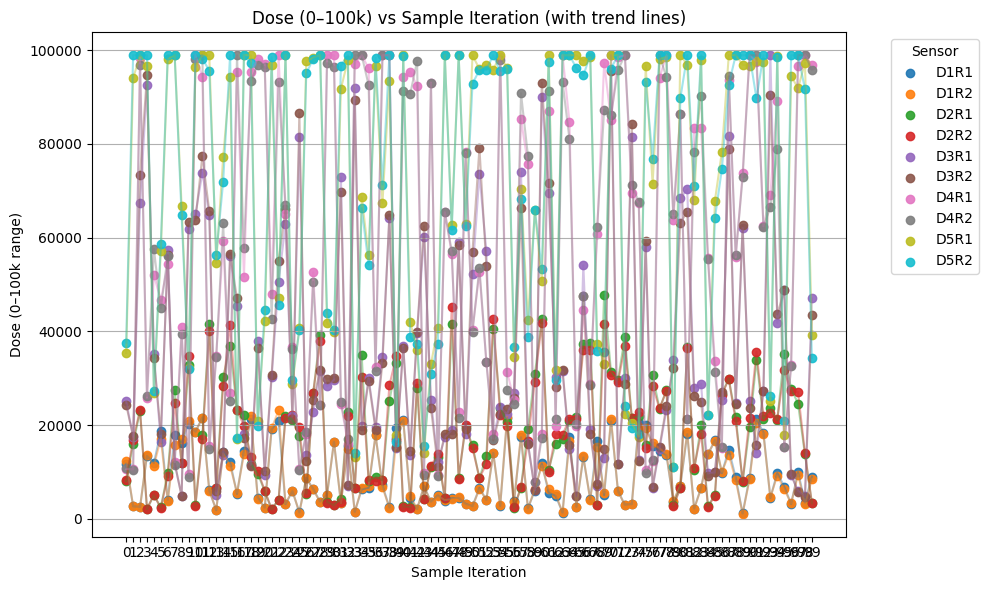

In [12]:
df = df.copy()
df["iteration"] = df.index // 10  # integer division: each 10 values = 1 iteration

plt.figure(figsize=(10, 6))

for sensor, grp in df.groupby("sensor"):
    # scatter points
    plt.scatter(grp["iteration"].astype(str),
                grp["dose 0-100k"],
                label=sensor, alpha=0.9)

    # trend line (sorted by iteration)
    grp_sorted = grp.sort_values("iteration")
    plt.plot(grp_sorted["iteration"].astype(str),
             grp_sorted["dose 0-100k"],
             alpha=0.4)  # semi-transparent line

plt.xlabel("Sample Iteration")
plt.ylabel("Dose (0–100k range)")
plt.title("Dose (0–100k) vs Sample Iteration (with trend lines)")
plt.legend(title="Sensor", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

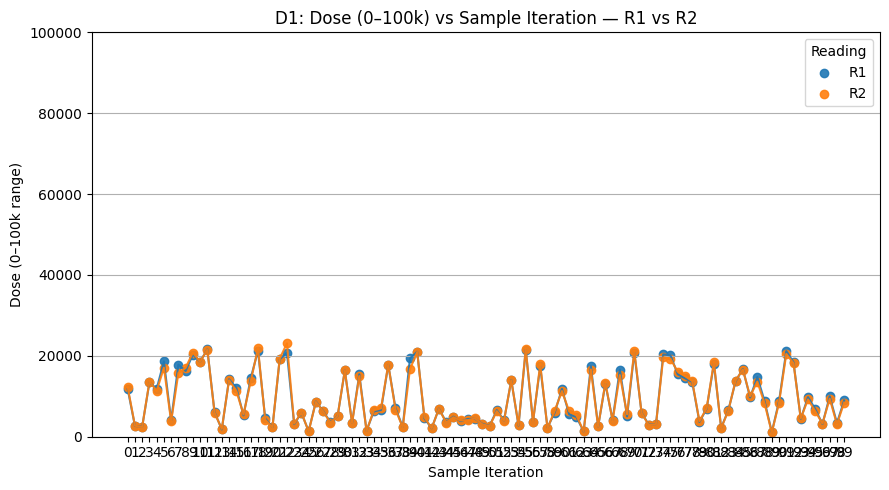

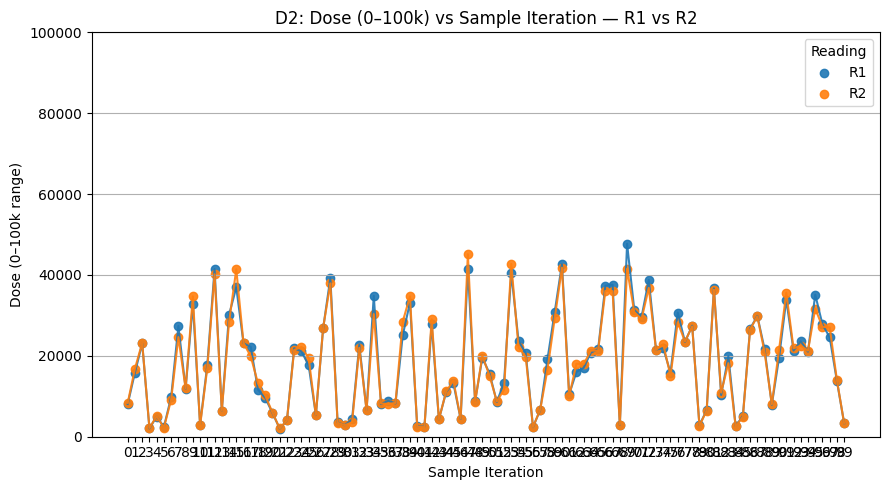

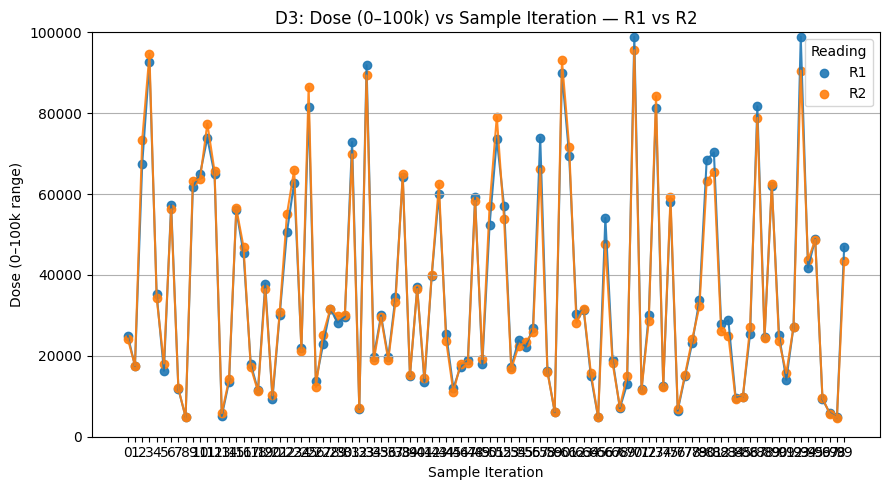

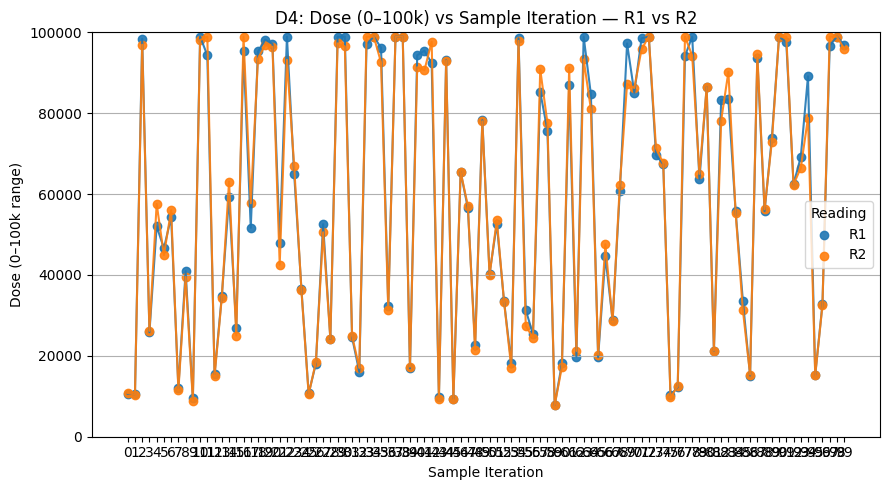

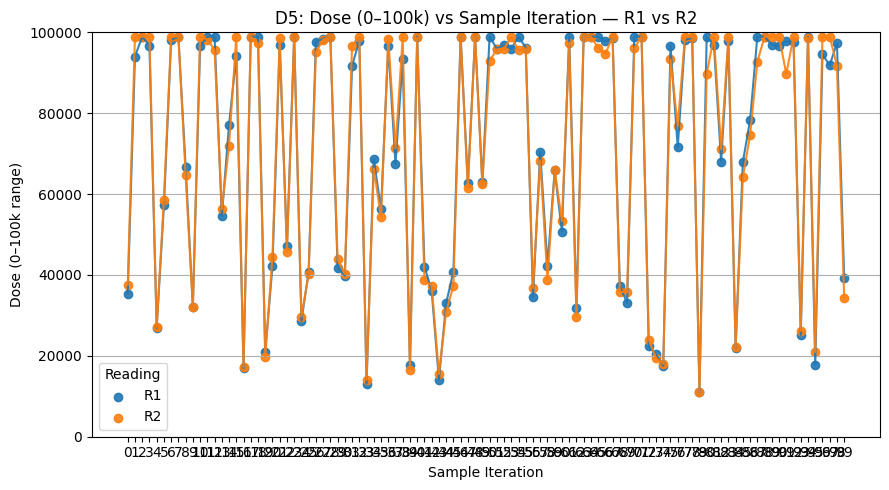

In [13]:

# Ensure dataframe `df` exists
if 'df' not in globals():
    raise RuntimeError("Dataframe `df` not found. Please run the previous cell that constructs `df` first.")

# Ensure iteration column exists
if "iteration" not in df.columns:
    df = df.copy()
    df["iteration"] = df.index // 10  # every 10 rows = 1 iteration

# Parse base sensor (D1..D5) and reading id (R1/R2) from "sensor" like "D3R2"
df = df.copy()
df["base_sensor"] = df["sensor"].str.extract(r"(D\d)R[12]")
df["read_id"] = df["sensor"].str.extract(r"D\d(R[12])")

# Iterate each base sensor and make a separate figure
for base in sorted(df["base_sensor"].unique(), key=lambda x: int(x[1:])):
    sub = df[df["base_sensor"] == base].sort_values(["iteration", "read_id"])

    plt.figure(figsize=(9, 5))
    # Plot R1 and R2 as separate series
    for rid, grp in sub.groupby("read_id"):
        # Use categorical x to keep it discrete
        xcat = grp["iteration"].astype(str)
        y = grp["dose 0-100k"]
        plt.scatter(xcat, y, label=rid, alpha=0.9)
        # Connect same R* across iterations to show trend
        # Sort by numeric iteration for the line
        g2 = grp.sort_values("iteration")
        plt.plot(g2["iteration"].astype(str), g2["dose 0-100k"], alpha=0.9)

    plt.xlabel("Sample Iteration")
    plt.ylabel("Dose (0–100k range)")
    plt.title(f"{base}: Dose (0–100k) vs Sample Iteration — R1 vs R2")
    plt.legend(title="Reading")
    plt.grid(True, axis="y")
    plt.ylim(0, 100000) 
    plt.tight_layout()
    plt.show()

In [14]:
# check for new csv packets (forever?) (every)
# take in data from partners 
# maybe in csv format?
# extrapolate samples from 26 byte packets
# if the crc isnt valid, disregard sample
# if valid samples have the same index and data, its a repeated sample, also disregard to not skew statistical analysis
# if valid samples have the same index but different data, and they both have a valid checksum, we'll know that there was a reset and the metadata wasnt loaded properly
# create dataframe from data and perform analysis